In [1]:
# Importing required libraries

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import GridSearchCV
import time
from scipy.ndimage.measurements import label
from queue import Queue
import random

%matplotlib inline
print('Library import successful')

Library import successful


In [2]:
# extracting HOG features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [3]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [4]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [5]:
# Define a function to extract features from a list of images
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [6]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def remove_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] -= 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [7]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [46]:
def find_cars(img, ystarts, ystops, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, colors, xstart=0):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    boxes = []
    for i in range(len(ystarts)):
        ystart = ystarts[i]
        ystop = ystops[i]
        scale = scales[i]
        color = colors[i]

        img_tosearch = img[ystart:ystop,xstart:,:]
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                #spatial_features = bin_spatial(subimg, size=spatial_size)
                #hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                test_features = X_scaler.transform(np.array(hog_features).reshape(1, -1))
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    boxes.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+xstart+win_draw,ytop_draw+win_draw+ystart)))
                    cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+xstart+win_draw,ytop_draw+win_draw+ystart),color,6) 
                
    return draw_img, boxes

In [47]:
# get model here
model = pickle.load(open('model4.p', 'rb'))
svc = model["classifier"]
X_scaler = model["scaler"]
color_space = model["colorspace"] # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = model["orient"]  # HOG orientations
pix_per_cell = model["pix_per_cell"] # HOG pixels per cell
cell_per_block = model["cell_per_block"] # HOG cells per block
hog_channel = model["hog_channel"] # Can be 0, 1, 2, or "ALL"
print(model)

{'pix_per_cell': 16, 'cell_per_block': 4, 'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'orient': 18, 'hog_channel': 'ALL', 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'colorspace': 'YCrCb'}


In [75]:
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
heat_threshold = 2
xstart = 384

#ystart = [400, 400, 464, 400, 440, 480, 400, 432, 464, 496, 528, 400, 448, 496, 544, 400, 432, 464, 496, 400, 416, 432, 448, 464, 480, 496]
#ystop  = [656, 592, 656, 560, 600, 640, 528, 560, 592, 624, 656, 496, 544, 592, 640, 464, 496, 528, 560, 432, 448, 464, 480, 496, 512, 528]
#scale  = [4.0, 3.0, 3.0, 2.5, 2.5, 2.5, 2.0, 2.0, 2.0, 2.0, 2.0, 1.5, 1.5, 1.5, 1.5, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

#ystart = [400, 400, 400, 400, 400]
#ystop  = [656, 624, 592, 560, 496]
#scale  = [4.0, 3.0, 2.0, 1.5, 0.5]

#ystart = [400, 432, 400, 400, 400, 432, 464, 496]
#ystop  = [656, 624, 656, 592, 464, 496, 528, 560]
#scale  = [4.0, 3.0, 2.0, 1.5, 1.0, 1.0, 1.0, 1.0]

#ystart = [416, 400, 416, 408, 400]
#ystop  = [672, 656, 544, 536, 528]
#scale  = [3.0, 3.0, 2.5, 2.0, 1.5]

#ystart = [ 400, 432, 464, 496, 400, 432, 464, 496, 416, 448, 480, 512]
#ystop  = [ 496, 528, 560, 592, 560, 592, 624, 656, 544, 576, 608, 640]
#scale  = [ 1.5, 1.5, 1.5, 1.5, 2.5, 2.5, 2.5, 2.5, 2.0, 2.0, 2.0, 2.0]

#ystart = [ 400, 464, 400, 432, 432]
#ystop  = [ 496, 560, 560, 592, 496]
#scale  = [ 1.5, 1.5, 2.5, 2.5, 0.5]

#ystart = [400, 432, 400, 400, 400]
#ystop  = [656, 624, 592, 592, 496]
#scale  = [4.0, 3.0, 2.0, 1.5, 1.0]

#ystart = [400, 400, 400, 432, 400, 464]
#ystop  = [656, 624, 464, 496, 496, 560]
#scale  = [4.0, 3.0, 0.5, 0.5, 1.5, 1.5]

####great 1#####
#ystart = [400, 400, 400, 400, 400, 400]
#ystop  = [656, 624, 592, 560, 528, 496]
#scale  = [4.0, 3.0, 2.0, 1.5, 1.0, 0.5]

### remarkable
#ystart = [400, 400, 400, 400, 384]
#ystop  = [656, 624, 624, 624, 624]
#scale  = [4.0, 3.0, 2.0, 1.5, 1.0]

#ystart = [400, 400, 400, 432, 464, 400, 384, 400, 400]
#ystop  = [656, 624, 656, 624, 624, 560, 512, 528, 496]
#scale  = [4.0, 3.0, 2.0, 2.0, 1.5, 1.5, 1.0, 1.0, 0.5]

#ystart = [400, 400, 400, 400, 384, 384, 392]
#ystop  = [656, 624, 624, 624, 608, 640, 520]
#scale  = [4.0, 3.0, 2.0, 1.5, 1.5, 1.0, 1.0]
#colors = [(0,0,255), (255,0,0), (0,255,0), (0,255,255), (255,255,0), (255,0,255), (255,255,255)]

ystart = [400, 400, 384, 384, 392]
ystop  = [624, 624, 608, 640, 520]
scale  = [2.0, 1.5, 1.5, 1.0, 1.0]
colors = [(0,0,255), (255,0,0), (0,255,0), (255,255,0), (255,255,255)]

ystart = [400, 432, 456, 408, 384, 384, 392, 400 , 420 ]
ystop  = [656, 624, 552, 504, 480, 512, 520, 480 , 540 ]
scale  = [2.0, 2.0, 1.5, 1.5, 1.5, 1.0, 1.0, 1.25, 1.25]
colors = [(0,0,0), (0,0,0), (255,0,0), (255,0,0), (255,0,0), (255, 255, 255), (255,255,255), (0, 255, 0), (0, 255, 0)]


0.95 Seconds to process image..
0.96 Seconds to process image..
0.95 Seconds to process image..
0.95 Seconds to process image..
0.96 Seconds to process image..
1.04 Seconds to process image..


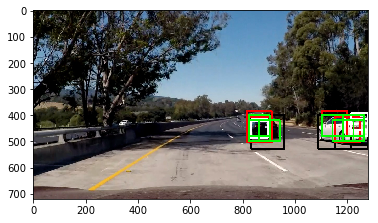

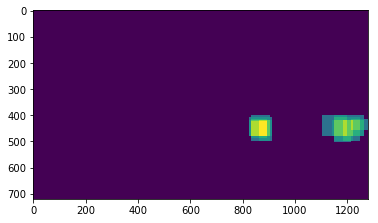

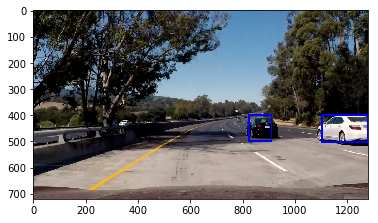

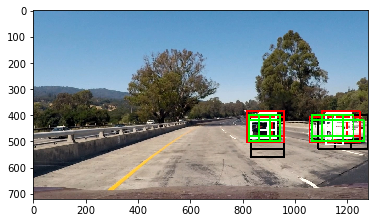

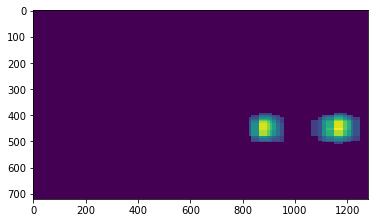

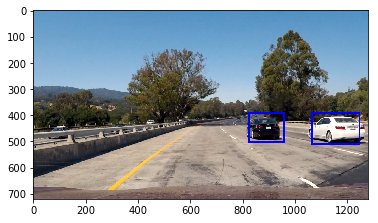

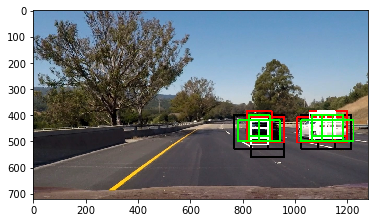

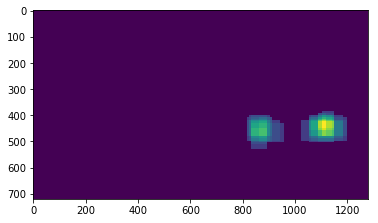

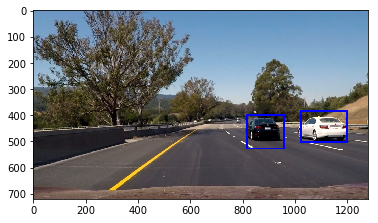

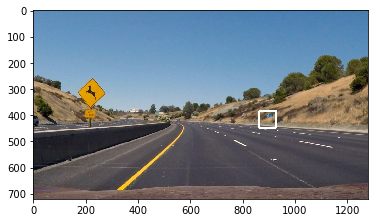

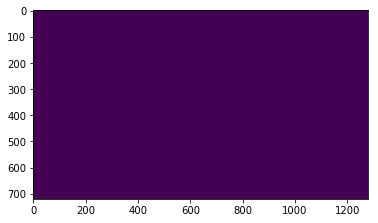

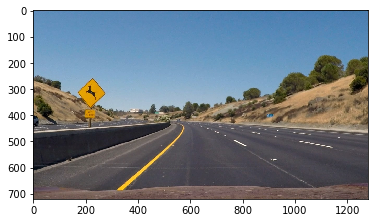

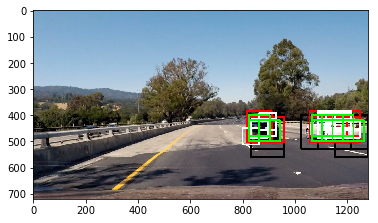

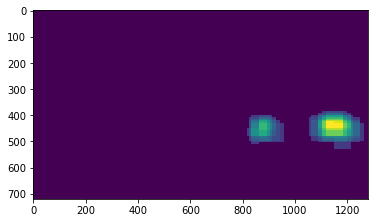

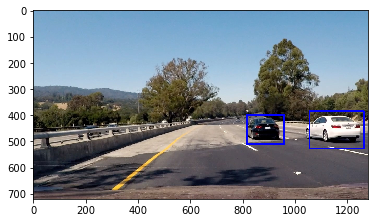

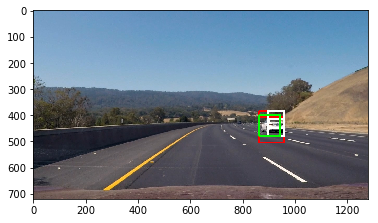

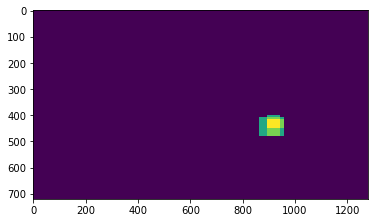

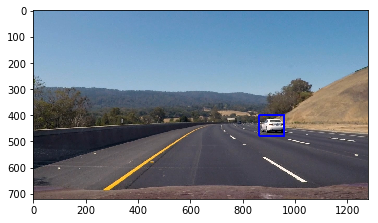

In [76]:
images = glob.glob('test_images/test*.jpg')
    
for image in images:
    t = time.time()
    image = mpimg.imread(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    out_img, boxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, colors, xstart)                    

    # Add heat to each box in box list
    heat = add_heat(heat,boxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,heat_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    '''heatmap_img = (np.dstack((heatmap, heatmap, heatmap))*255).astype(np.uint8)
    stack1 = np.hstack((heatmap_img, out_img))
    stack2 = cv2.resize(stack1, (draw_img.shape[1], 360))
    stack3 = np.vstack((stack2, draw_img))
    plt.imshow(stack3)
    plt.figure()'''
    plt.imshow(out_img)
    plt.figure()
    plt.imshow(heatmap)
    plt.figure()
    plt.imshow(draw_img)
    plt.figure()
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to process image..')

In [93]:
heat_threshold = 4
heat = np.zeros_like(image[:,:,0]).astype(np.float)
box_queue = Queue(maxsize=10)


In [94]:
def process_image(image):
    
    global heat_threshold
    global heat
    global box_queue
    global count
    global pre_img
    if count%3==0:
        
        if box_queue.full():
            heat = remove_heat(heat,box_queue.get())
    
        out_img, boxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, colors, xstart)                    

        # Add heat to each box in box list
        heat = add_heat(heat,boxes)
        box_queue.put(boxes)
        current_heat = np.copy(heat)
        if (not box_queue.full()) and heat_threshold < 40 and len(boxes) > 1:
            heat_threshold += 2
            
        if heat_threshold > 4 and len(boxes) < 2:
            heat_threshold -= 0.5
            
        # Apply threshold to help remove false positives
        current_heat = apply_threshold(current_heat,heat_threshold)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(current_heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)

        result = draw_labeled_bboxes(np.copy(image), labels)
        
        heat_img = (np.dstack((heat, heat, heat))*255).astype(np.uint8)
        cv2.putText(heat_img,'average heat: ' + str(np.average(heat)), (10,500), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        heatmap_img = (np.dstack((heatmap, heatmap, heatmap))*255).astype(np.uint8)
        stack1 = np.hstack((heat_img, out_img, heatmap_img))
        #stack2 = np.hstack((result, result))
        #stack2 = cv2.resize(stack1, (result.shape[1], result.shape[0]))
        stack2 = cv2.resize(stack1, (result.shape[1], 360))
        stack3 = np.vstack((stack2, result))
        
        pre_img = stack3
    else:
        pass
    count = count + 1
    return pre_img

In [95]:
white_output = './test_videos_output/project_video_output_20180319_1350.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("./project_video.mp4").subclip(20,25)
pre_img = None
count=0
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./test_videos_output/project_video_output_20180319_1350.mp4
[MoviePy] Writing video ./test_videos_output/project_video_output_20180319_1350.mp4


100%|█████████▉| 1260/1261 [05:48<00:00,  3.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos_output/project_video_output_20180319_1350.mp4 

CPU times: user 6min 38s, sys: 780 ms, total: 6min 38s
Wall time: 5min 49s


In [92]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))